In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = './data/finalimage/'
sz = 224
arch = resnext101_64
bs = 64
!ls {PATH}

table.csv  test  train


In [4]:
label_csv = f'{PATH}table.csv'
n = len(list(open(label_csv))) - 1 # No. rows in the CSV file, -1 because of header
print('Total No. of Data:', n)
val_idxs = get_cv_idxs(n) # select random 20% rows as Validation Data
print(val_idxs, '\nval datasets:',len(val_idxs))

Total No. of Data: 14235
[ 4115  2974 12093 ...  3334  5404  1091] 
val datasets: 2847


In [5]:
label_df = pd.read_csv(label_csv)

In [6]:
label_df.head()

,Image Index,Finding Labels
0,00000001_001.png,Cardiomegaly
1,00000004_000.png,Mass
2,00000005_007.png,Effusion
3,00000008_000.png,Cardiomegaly
4,00000009_000.png,Emphysema


In [7]:
label_df.pivot_table(index='Finding Labels', aggfunc=len).sort_values('Image Index', ascending=False)

,Image Index
Finding Labels,
Infiltration,4281
Atelectasis,2968
Effusion,1382
Nodule,1138
Mass,881
Cardiomegaly,875
Consolidation,625
Fibrosis,516
Pleural_Thickening,466


In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}table.csv', test_name='test', val_idxs = val_idxs, tfms=tfms, bs=bs)

In [9]:
fn = PATH+data.trn_ds.fnames[0]; fn

'./data/finalimage/train/00000001_001.png'

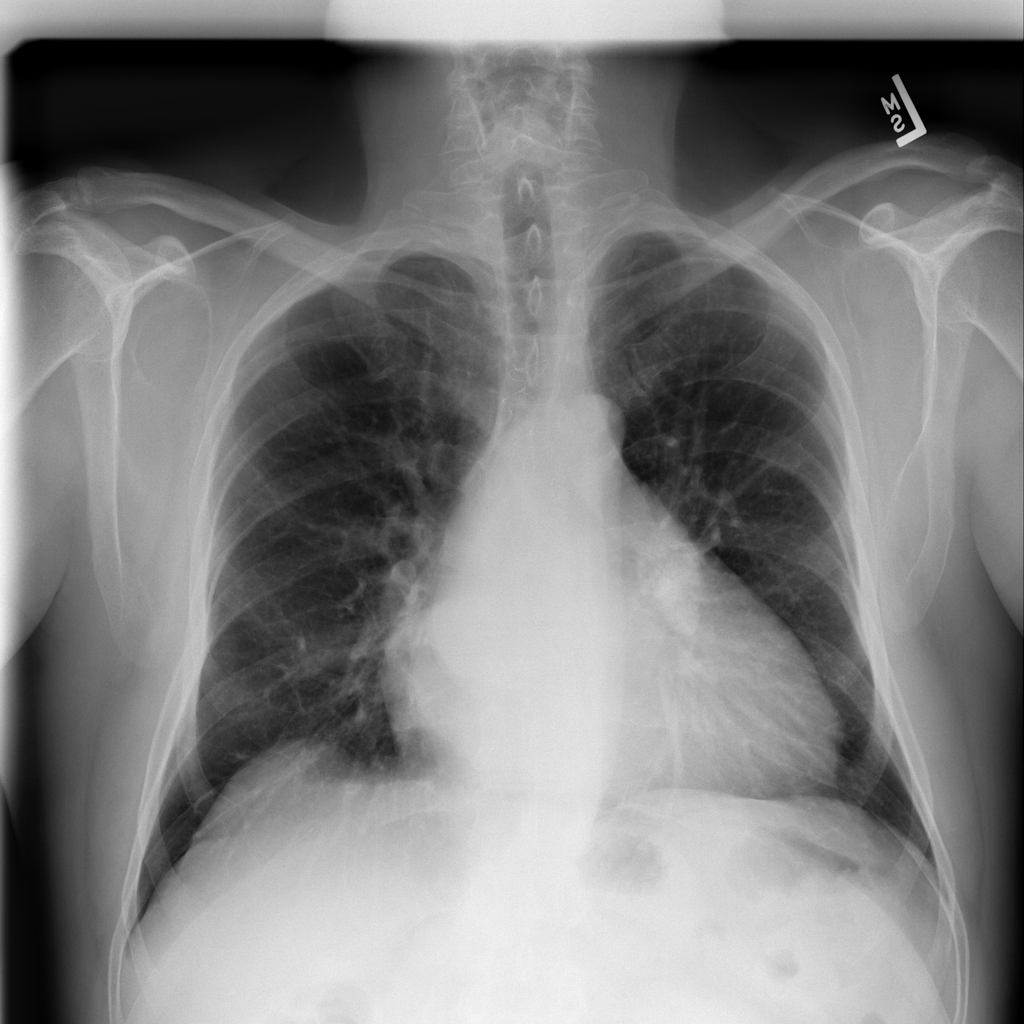

In [10]:
# img = PIL.Image.open(fn); img

In [11]:
img.size

(1024, 1024)

In [12]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [13]:
len(data.trn_ds), len(data.test_ds)

(11388, 547)

In [14]:
len(data.classes), data.classes[:10]

(12,
 ['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Infiltration',
  'Mass',
  'Nodule'])

In [15]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}table.csv', test_name='test', num_workers = 4,
                                    val_idxs = val_idxs, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [17]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                   
    0      2.094753   1.949946   0.365983  
    1      2.002973   1.940165   0.364919                   
    2      1.962659   1.919621   0.364897                   



[1.9196208, 0.3648969531059265]

### Augment

In [18]:
from sklearn import metrics

In [19]:
data = get_data(sz, bs)

In [20]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps = 0.5)

100%|██████████| 9/9 [00:34<00:00,  3.81s/it]


In [21]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.094942   1.941365   0.364247  
    1      1.978371   1.936846   0.363161                   



[1.9368459, 0.3631608419948154]

In [22]:
learn.precompute = False

In [23]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.950237   1.917748   0.36455   
    1      1.949845   1.913333   0.363508                   
    2      1.908442   1.908255   0.369108                   
    3      1.907934   1.914071   0.362511                   
    4      1.890384   1.904713   0.373275                   



[1.9047132, 0.373275089263916]

In [24]:
learn.save('224_pre')
learn.load('224_pre')

In [25]:
learn.set_data(get_data(299, bs))
learn.freeze()

In [26]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.947485   1.903276   0.371147  
    1      1.908259   1.896875   0.376703                   
    2      1.925601   1.901992   0.372905                   



[1.9019924, 0.3729054656293657]

In [27]:
learn.fit(1e-2, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.918609   1.89378    0.380892  
    1      1.915723   1.8995     0.382975                   
    2      1.863836   1.880568   0.382953                   



[1.8805678, 0.38295250866148206]

In [28]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.3860203723217422

In [29]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[364  10   0   0  23   4   1 197   0   3   0   0]
 [ 55  30   0   0   7   0   0  90   1   1   0   1]
 [ 54   1   0   1   5   1   1  55   1   0   0   0]
 [ 35   2   0   4   4   0   0  29   0   0   0   0]
 [129   3   0   1  56   0   1  67   1   2   0   0]
 [ 36   0   0   0   7   1   0  41   0   3   0   1]
 [ 27   4   0   0   7   0   2  70   0   3   0   0]
 [157  11   0   1  23   0   0 632   1   7   0   0]
 [ 56   1   0   0   8   0   0  94   3   2   0   1]
 [ 63   2   0   0   9   0   2 152   1   7   0   0]
 [ 26   4   0   0   8   0   0  69   0   1   0   0]
 [ 22   0   0   0   2   0   1  39   0   0   0   0]]


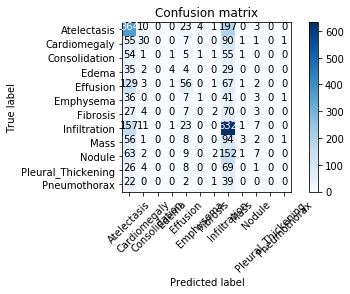

In [31]:
plot_confusion_matrix(cm, data.classes)

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
lrf=learn.lr_find()

 86%|████████▌ | 153/178 [00:30<00:04,  5.10it/s, loss=15.2]

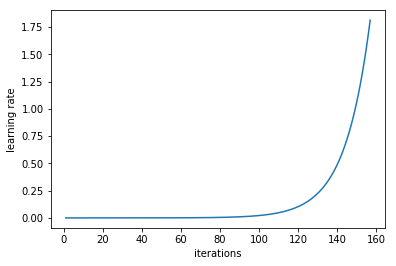

In [34]:
learn.sched.plot_lr()

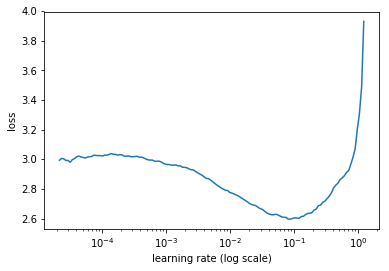

In [35]:
learn.sched.plot()